# Projet TAL



## Ce document est composé comme suit :

0. Importation des bibliothèques
1. Observation des données
2. Nettoyage
  * V1(regex), V2(regex + stop words), V3(spacy)
3. Encodage des labels
4. TF-IDF
5. TF-IDF + Baseline
6. TF-IDF + SVM
  * V1 normal
  * V2 avec score pour l'analyse
7. Analyse
8. Autres modèles
  * TF-IDF + GridSearch
  * TF-IDF + XGB
  * TF-IDF + Naïve Bayes
  * TF-IDF + Random Forest
9. Embeddings
10. Embeddings + SVM
11. Autres modèles
  * Embeddings + Gaussian Naïve Bayes
  * Embeddings + Random Forest

---
---
---

## Importation des bibliothèques

In [ ]:
!python -m spacy download fr_core_news_md

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 MB 10.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('fr_core_news_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [3]:
!pip install gensim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 49.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 11.3 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scipy
    Found existing installation: scipy 1.14.1
    Uninstalling scipy-1.14.1:
      Successfully uninstalled scipy-1.14.1


In [1]:
import pandas as pd
import re
import spacy
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
import gensim
from gensim.models import Word2Vec
from sklearn.naive_bayes import GaussianNB

## Observation des données


In [2]:
# Charger les fichiers
df_train = pd.read_csv("../data/train.csv")
df_test = pd.read_csv("../data/test.csv")

In [3]:
print(df_train.info())  # Vérifier les types de données
print(df_train.head())  # Afficher les premières lignes
print(df_train.isnull().sum())  # Vérifier les valeurs manquantes
print(df_train["type"].value_counts())  # Répartition des classes
print(df_train["recette"].iloc[0])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12473 entries, 0 to 12472
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   doc_id       12473 non-null  object
 1   titre        12473 non-null  object
 2   type         12473 non-null  object
 3   difficulte   12473 non-null  object
 4   cout         12473 non-null  object
 5   ingredients  12473 non-null  object
 6   recette      12473 non-null  object
dtypes: object(7)
memory usage: 682.2+ KB
None
               doc_id                                              titre  \
0  recette_221358.xml  Feuilleté de saumon et de poireau, sauce aux c...   
1   recette_48656.xml                       Cake poulet/moutarde/amandes   
2   recette_30049.xml           Bûche à la truite fumée (7ème rencontre)   
3   recette_71424.xml    Gâteau au yaourt au coco sans huile de laetitia   
4  recette_217204.xml                             Crêpes au canard laqué   

             type  

* 7 Colones : doc_id, titre, type, difficulte, cout, ingredients, recette
1. Pour train.csv :
* Aucunes valeurs manquantes
* Répartition des 3 types de plats (12473 plats):
  * Plat principal    5802
  * Dessert           3762
  * Entrée            2909

2. Pour test.csv :
* Aucunes valeurs manquantes
* Répartition des 3 types de plats (1388 plats):
  * Plat principal    644
  * Dessert           407
  * Entrée            337

---

## Nettoyage

> Clean V1

In [4]:
# Nettoyage du texte
def clean_text(text):
    text = re.sub(r'\d+', '', text)  # Supprimer les chiffres
    text = re.sub(r'[^\w\s]', '', text)  # Supprimer la ponctuation
    return text

df_train["texte"] = (df_train["titre"] + " " + df_train["recette"]).apply(clean_text)
df_test["texte"] = (df_test["titre"] + " " + df_test["recette"]).apply(clean_text)

print(df_train["texte"].iloc[0])


Feuilleté de saumon et de poireau sauce aux crevettes Couper finement le blanc et un peu de vert des poireaux en rondelle Éplucher et couper loignon Faire chauffer lhuile dolive et le beurre dans une poêle Y faire revenir à feu doux les poireaux et loignon environ  minutes En fin de cuisson ajouter le vin blanc un peu daneth et du sel Pendant ce temps faire cuire le saumon dans une poêle huilée En fin de cuisson le faire griller sur feu vif Préparer la sauce  mélanger les crevettes le  citron jaune la crème le sel et laneth Ajouter un peu de sauce à la préparation des poireaux Préchauffer le four à C thermostat Étaler la pâte feuilletée et la couper en  Sur une moitié disposer la préparation au poireaux Disposer le saumon sur les poireaux Y verser un peu de sauce sur le dessus garder le reste de sauce au frigo Refermer le chausson à laide de lautre moitié de la pâte feuilleté Bien appuyer sur les bords Étaler le jaune dœuf sur le dessus à laide dun pinceau Enfourner environ  minutes Av

> Clean V2

In [ ]:
# Liste des stop words
stopwords = set(
    "je tu il elle nous vous ils elles on me te se le la les de du des un une et à en pour avec que qui dans ne pas ce cette ces au aux son sa ses leur leurs y c".split()
)

# Nettoyage du texte
def clean_text_v2(text):
    text = text.lower()  # Convertir en minuscules
    text = re.sub(r'\d+', '', text)  # Supprimer les chiffres
    text = re.sub(r'[^\w\s]', '', text)  # Supprimer la ponctuation
    text = re.sub(r'\s+', ' ', text).strip()  # Supprimer les espaces inutiles
    text = ' '.join([word for word in text.split() if word not in stopwords])  # Supprimer les stop words
    return text

# Application du nettoyage aux données
df_train["texte"] = (df_train["titre"] + " " + df_train["recette"]).apply(clean_text_v2)
df_test["texte"] = (df_test["titre"] + " " + df_test["recette"]).apply(clean_text_v2)

print(df_train["texte"].iloc[0])


feuilleté saumon poireau sauce crevettes couper finement blanc peu vert poireaux rondelle éplucher couper loignon faire chauffer lhuile dolive beurre poêle faire revenir feu doux poireaux loignon environ minutes fin cuisson ajouter vin blanc peu daneth sel pendant temps faire cuire saumon poêle huilée fin cuisson faire griller sur feu vif préparer sauce mélanger crevettes citron jaune crème sel laneth ajouter peu sauce préparation poireaux préchauffer four thermostat étaler pâte feuilletée couper sur moitié disposer préparation poireaux disposer saumon sur poireaux verser peu sauce sur dessus garder reste sauce frigo refermer chausson laide lautre moitié pâte feuilleté bien appuyer sur bords étaler jaune dœuf sur dessus laide dun pinceau enfourner environ minutes avant servir chauffer sauce servir côté feuilletéon peut servir feuilleté salade verte


> Clean V3 (exec=9min)

In [ ]:
nlp = spacy.load("fr_core_news_md")

# Nettoyage du texte
def clean_text_v3(text):
    doc = nlp(text)
    word = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]
    return ' '.join(word)

# Application du nettoyage aux données
df_train["texte"] = (df_train["titre"] + " " + df_train["recette"]).apply(clean_text_v3)
df_test["texte"] = (df_test["titre"] + " " + df_test["recette"]).apply(clean_text_v3)

print(df_train["texte"].iloc[0])

Feuilleté saumon poireau sauce crevette couper finement blanc vert poireau rondelle éplucher couper oignon faire chauffer huile olive beurre poêle faire revenir feu doux poireau oignon 15 minute fin cuisson ajouter vin blanc aneth sel temps faire cuire saumon poêle huiler fin cuisson faire griller feu vif préparer sauce mélanger crevette 1/2 citron jaune crème sel aneth ajouter sauce préparation poireau préchauffer four 200 degré c thermostat 6 7.étaler pâte feuilleter couper 2 moitié disposer préparation poireau disposer saumon poireau verser sauce garder sauce frigo refermer chausson aide moitié pâte feuilleté bien appuyer bord étaler jaune œuf aide pinceau enfourner 20 minute servir chauffer sauce servir côté feuilleté servir feuilleté salade vert


---
## Encodage des labels

In [5]:
# Encodage des labels
encoder = LabelEncoder()
df_train["label"] = encoder.fit_transform(df_train["type"])  # 0 = Dessert, 1 = Entrée, 2 = Plat principal
df_test["label"] = encoder.transform(df_test["type"])

print(df_train["label"].value_counts())


label
2    5802
0    3762
1    2909
Name: count, dtype: int64


---
## TF-IDF

In [6]:
# TF-IDF
vectorizer = TfidfVectorizer(max_features=5000, sublinear_tf=True)
X_train = vectorizer.fit_transform(df_train["texte"])
X_test = vectorizer.transform(df_test["texte"])
y_train = df_train["label"]
y_test = df_test["label"]

print(X_train.shape, X_test.shape)

(12473, 5000) (1388, 5000)


---
## Baseline


In [ ]:
# Classes cibles
labels = df_train["label"].unique()

# Générer des prédictions aléatoires
y_pred_random = np.random.choice(labels, size=len(y_test))  # Taille égale à celle de y_test

# Évaluation des prédictions aléatoires
print("Accuracy:", accuracy_score(y_test, y_pred_random))
print("Classification Report:\n", classification_report(y_test, y_pred_random))


Accuracy: 0.3314121037463977
Classification Report:
               precision    recall  f1-score   support

           0       0.31      0.36      0.33       407
           1       0.23      0.31      0.27       337
           2       0.45      0.32      0.38       644

    accuracy                           0.33      1388
   macro avg       0.33      0.33      0.33      1388
weighted avg       0.36      0.33      0.34      1388



### Résultats
Mauvais avec environ 0.33 d'accuracy

---
## Entraînement SVM avec TF-IDF (exec=2min)


> V1

In [7]:
# Initialiser et entraîner le modèle
model = SVC(kernel="rbf")
model.fit(X_train, y_train)

# Prédictions
y_pred = model.predict(X_test)

# Évaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.8912103746397695
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99       407
           1       0.81      0.75      0.78       337
           2       0.88      0.90      0.89       644

    accuracy                           0.89      1388
   macro avg       0.89      0.88      0.88      1388
weighted avg       0.89      0.89      0.89      1388



### Résultats
Très bon avec 0.891 d'accuracy

### Entraînement SVM avec TF-IDF (avec les probabilités d'apartenance)(exec=11min)

> V2

In [ ]:
# Initialiser et entraîner le modèle
model = SVC(kernel="rbf", probability=True)
model.fit(X_train, y_train)

# Prédictions
y_pred = model.predict(X_test)

# Prédire les probabilités
y_scores = model.predict_proba(X_test)

# Évaluation
print(y_scores[:5])  # Affiche les premières probabilités
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


[[9.99556257e-01 3.56462438e-04 8.72801643e-05]
 [9.95580218e-01 9.79853507e-04 3.43992866e-03]
 [7.74069745e-04 4.38380181e-02 9.55387912e-01]
 [1.05289014e-03 1.13521509e-01 8.85425601e-01]
 [4.26950948e-05 9.39095904e-01 6.08614007e-02]]
Accuracy: 0.8912103746397695
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99       407
           1       0.81      0.75      0.78       337
           2       0.88      0.90      0.89       644

    accuracy                           0.89      1388
   macro avg       0.89      0.88      0.88      1388
weighted avg       0.89      0.89      0.89      1388



# Analyse

In [ ]:
print("Nombre de documents avec un score de 0 :", np.sum(y_scores == 0))
print("Nombre de documents avec un score de 0.5 :", np.sum(y_scores == 0.5))
print("Nombre de documents avec un score de 1 :", np.sum(y_scores == 1))
print("----------")
print("Nombre de documents avec un score < 0.05 :", np.sum(y_scores < 0.05))
print("Nombre de documents avec un score entre 0.4 et 0.6 :", np.sum((y_scores > 0.4) & (y_scores < 0.6)))
print("Nombre de documents avec un score > 0.95 :", np.sum(y_scores > 0.95))

Nombre de documents avec un score de 0 : 0
Nombre de documents avec un score de 0.5 : 0
Nombre de documents avec un score de 1 : 0
Nombre de documents avec un score de 1 : 4164
----------
Nombre de documents avec un score < 0.05 : 2050
Nombre de documents avec un score entre 0.4 et 0.6 : 183
Nombre de documents avec un score > 0.95 : 678


SVM n’est pas un modèle 100% sûr donc les scores sont proches mais pas égale à 1 ou 0.

On interprête ici sur 3 classe x 1338 recettes = 4164 cas

Le modèle est très confiant pour 678 cas. \
Le modèle rejette fortement certaines classes pour 2050 cas. \
Le modèle ne sait pas bien classer 183 cas.

### Courbe ROC :

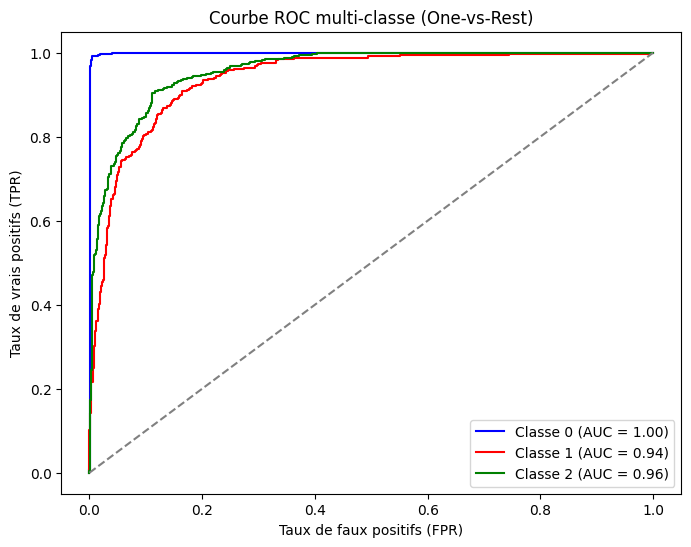

In [ ]:
# Binariser les labels pour multi-classes (ex: 3 classes → one-hot encoding)
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])

# Initialiser la figure
plt.figure(figsize=(8, 6))
colors = ['blue', 'red', 'green']

# Tracer une courbe ROC par classe
for i in range(3):  # 3 classes
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_scores[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=colors[i], label=f'Classe {i} (AUC = {roc_auc:.2f})')

# Ajouter une diagonale (modèle aléatoire)
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')

# Labels et affichage
plt.xlabel('Taux de faux positifs (FPR)')
plt.ylabel('Taux de vrais positifs (TPR)')
plt.title('Courbe ROC multi-classe (One-vs-Rest)')
plt.legend(loc='lower right')
plt.show()


 ### Interprétation
 Classe 0 = Dessert, Classe 1 = Entrée, Classe 2 = Plat principal

 Classes 1 et 2 ont quelques erreurs mais restent très bien séparées. \
 Classe 0 est classée de manière prèsque parfaite.

Cas de prédiction incorrecte :

In [ ]:
# Obtenir les prédictions du modèle
y_pred = model.predict(X_test)

# Ajouter les résultats à un DataFrame pour analyse
df_test_results = df_test.copy()
df_test_results["y_true"] = y_test
df_test_results["y_pred"] = y_pred

# Identifier les erreurs
df_errors = df_test_results[df_test_results["y_true"] != df_test_results["y_pred"]]

df_errors.head(5)


,doc_id,titre,type,difficulte,cout,ingredients,recette,texte,label,tokens,y_true,y_pred
26,recette_20525.xml,Soupe d'hiver aux pommes de terre,Plat principal,Très facile,Bon marché,- 10 grandes pommes de terre farineuses - 4 ca...,Faire cuire les pommes de terre dans de l'eau ...,Soupe dhiver aux pommes de terre Faire cuire l...,2,"[Soupe, dhiver, aux, pommes, de, terre, Faire,...",2,1
47,recette_173201.xml,Le grillé aux Pommes,Dessert,Facile,Bon marché,- 1 pâte feuilletée - -3 pommes - -50g de beur...,Préchauffez votre four a 175°C (th6). -Dans la...,Le grillé aux Pommes Préchauffez votre four a ...,0,"[Le, grillé, aux, Pommes, Préchauffez, votre, ...",0,2
49,recette_60844.xml,Salade de pâtes fraîches,Entrée,Facile,Bon marché,"- 2 petites courgettes bio, jaune et verte - 1...",Faites cuire les torsades al dente avec un bou...,Salade de pâtes fraîches Faites cuire les tors...,1,"[Salade, de, pâtes, fraîches, Faites, cuire, l...",1,2
56,recette_73239.xml,Tarte au thon et tomate facile,Entrée,Très facile,Bon marché,- 1 pâte feuilletée - thon naturel en boîte - ...,Couper 1 oignon en petits morceaux et le faire...,Tarte au thon et tomate facile Couper oignon ...,1,"[Tarte, au, thon, et, tomate, facile, Couper, ...",1,2
57,recette_58672.xml,Chausson vichy au jambon,Entrée,Facile,Bon marché,- 1 pâte feuilletée - 4 tranches de jambon bla...,Préchauffer le four à 190°C (thermostat 6-7). ...,Chausson vichy au jambon Préchauffer le four à...,1,"[Chausson, vichy, au, jambon, Préchauffer, le,...",1,2


### Matrice de confusion :

In [ ]:
# Tableau des erreurs de classification
confusion_matrix = pd.crosstab(df_test_results["y_true"], df_test_results["y_pred"], rownames=["Vrai"], colnames=["Prédit"])

print(confusion_matrix)


Prédit    0    1    2
Vrai                 
0       404    1    2
1         4  252   81
2         4   59  581


Le modèle se trompe majoritairement sur la différence entre les classes 'plat principal' et 'entrée'.

---
## Autres modèles

### TF-IDF + GridSearch (exec=8min):

In [ ]:
# Définir la grille de paramètres
param_grid = {
    'C': [1],
    'kernel': ['rbf']
}

# Création du modèle avec recherche des meilleurs hyperparamètres
svm = SVC()
grid_search = GridSearchCV(svm, param_grid, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Meilleur modèle
best_svm = grid_search.best_estimator_
print("Meilleurs paramètres :", grid_search.best_params_)

# Évaluation sur le test
y_pred = best_svm.predict(X_test)
print("Optimized SVM Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Meilleurs paramètres : {'C': 1, 'kernel': 'rbf'}
Optimized SVM Accuracy: 0.8912103746397695
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99       407
           1       0.81      0.75      0.78       337
           2       0.88      0.90      0.89       644

    accuracy                           0.89      1388
   macro avg       0.89      0.88      0.88      1388
weighted avg       0.89      0.89      0.89      1388



GridSearch : 0.891 d'accuracy car c'est les meilleurs paramètres de SVC()

### TF-IDF + XGB (exec=3min30s):

In [ ]:
xgb = XGBClassifier(n_estimators=200, learning_rate=0.1, max_depth=6)
xgb.fit(X_train, y_train)

y_pred_xgb = xgb.predict(X_test)
print("XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("Classification Report:\n", classification_report(y_test, y_pred_xgb))


XGBoost Accuracy: 0.8631123919308358
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98       407
           1       0.76      0.68      0.72       337
           2       0.84      0.89      0.86       644

    accuracy                           0.86      1388
   macro avg       0.86      0.85      0.85      1388
weighted avg       0.86      0.86      0.86      1388



XGB: 0.86 d'accuracy

### TF-IDF + Naïve Bayes(exec=1s):

In [ ]:
# Modèle Naïve Bayes (bon pour du texte)
model_nb = MultinomialNB()
model_nb.fit(X_train, y_train)
y_pred_nb = model_nb.predict(X_test)
print("Naïve Bayes Accuracy:", accuracy_score(y_test, y_pred_nb))
print("Naïve Bayes Classification Report:\n", classification_report(y_test, y_pred_nb))


Naïve Bayes Accuracy: 0.8350144092219021
Naïve Bayes Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.98      0.97       407
           1       0.80      0.47      0.59       337
           2       0.78      0.93      0.85       644

    accuracy                           0.84      1388
   macro avg       0.84      0.80      0.80      1388
weighted avg       0.84      0.84      0.82      1388



Naïves Bayes : 0.83 d'accuracy

### TF-IDF + Random Forest (exec=30s):

In [ ]:
# Modèle Random Forest
model_rf = RandomForestClassifier(n_estimators=100, random_state=42)
model_rf.fit(X_train, y_train)
y_pred_rf = model_rf.predict(X_test)
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Random Forest Classification Report:\n", classification_report(y_test, y_pred_rf))

Random Forest Accuracy: 0.8342939481268011
Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.99      0.97       407
           1       0.83      0.44      0.57       337
           2       0.77      0.94      0.85       644

    accuracy                           0.83      1388
   macro avg       0.85      0.79      0.80      1388
weighted avg       0.84      0.83      0.82      1388



Random Forest : 0.83 d'accuracy

---
## Test avec embeddings à la place de TF-IDF

In [ ]:
# Tokenisation : transformer chaque texte en liste de mots
df_train["tokens"] = df_train["texte"].apply(lambda x: x.split())
df_test["tokens"] = df_test["texte"].apply(lambda x: x.split())

Utilisation de Word2Vec (exec=30s):

In [ ]:
# Entraîner un modèle Word2Vec sur les textes tokenisés
word2vec_model = Word2Vec(sentences=df_train["tokens"], vector_size=200, window=5, min_count=2, workers=4)

# Vérifier quelques mots
print(word2vec_model.wv.most_similar("chocolat", topn=5))


[('rhum', 0.6230478286743164), ('caramel', 0.6194989681243896), ('cacao', 0.6175707578659058), ('glaçage', 0.6172404885292053), ('mascarpone', 0.5820054411888123)]


Conversion texte en embeddings :

In [ ]:
# Fonction pour convertir un texte en vecteur moyen d'embeddings
def text_to_embedding(text_tokens, model):
    word_vectors = [model.wv[word] for word in text_tokens if word in model.wv]
    if len(word_vectors) == 0:  # Si aucun mot du texte n'est dans le modèle
        return np.zeros(model.vector_size)
    return np.mean(word_vectors, axis=0)

# Transformer tous les textes en embeddings
X_train_embeddings = np.array([text_to_embedding(tokens, word2vec_model) for tokens in df_train["tokens"]])
X_test_embeddings = np.array([text_to_embedding(tokens, word2vec_model) for tokens in df_test["tokens"]])


Encoder les labels :

In [ ]:
le = LabelEncoder()
y_train_encoded = le.fit_transform(df_train["label"])
y_test_encoded = le.transform(df_test["label"])

print(X_train_embeddings.shape, X_test_embeddings.shape)

(12473, 200) (1388, 200)


## Entraînement SVM avec embeddings (exec=40s)


In [ ]:
# Créer et entraîner un modèle SVM
svm_model = SVC()
svm_model.fit(X_train_embeddings, y_train_encoded)

# Prédiction et Évaluation
y_pred = svm_model.predict(X_test_embeddings)

accuracy = accuracy_score(y_test_encoded, y_pred)
print(f"Accuracy: {accuracy}")

# Afficher le classification report
target_names = [str(cls) for cls in le.classes_]
print("Classification Report:\n", classification_report(y_test_encoded, y_pred, target_names=target_names))


Accuracy: 0.8314121037463977
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.99      0.97       407
           1       0.75      0.50      0.60       337
           2       0.79      0.90      0.84       644

    accuracy                           0.83      1388
   macro avg       0.83      0.80      0.80      1388
weighted avg       0.83      0.83      0.82      1388



### Résultats
Reste bon avec environ 0.83 d'accuracy mais un moins bien qu'avec TF-IDF

## Autres modèles

### Embeddings + Gaussian Naïve Bayes (exec=1s):

In [ ]:
# Modèle Naïve Bayes adapté aux données continues
model_nb = GaussianNB()
model_nb.fit(X_train_embeddings, y_train_encoded)
y_pred_nb = model_nb.predict(X_test_embeddings)
print("Naïve Bayes (GaussianNB) Accuracy:", accuracy_score(y_test_encoded, y_pred_nb))
print("Naïve Bayes Classification Report:\n", classification_report(y_test_encoded, y_pred_nb))

Naïve Bayes (GaussianNB) Accuracy: 0.7219020172910663
Naïve Bayes Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.94      0.89       407
           1       0.47      0.53      0.50       337
           2       0.79      0.69      0.74       644

    accuracy                           0.72      1388
   macro avg       0.70      0.72      0.71      1388
weighted avg       0.73      0.72      0.72      1388



GaussianNB : 0.72 d'accuracy

### Embeddings + Random Forest (exec=40s):

In [ ]:
# Modèle Random Forest
model_rf = RandomForestClassifier(n_estimators=100, random_state=42)
model_rf.fit(X_train_embeddings, y_train_encoded)
y_pred_rf = model_rf.predict(X_test_embeddings)
print("Random Forest Accuracy:", accuracy_score(y_test_encoded, y_pred_rf))
print("Random Forest Classification Report:\n", classification_report(y_test_encoded, y_pred_rf))

Random Forest Accuracy: 0.797550432276657
Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.98      0.94       407
           1       0.68      0.40      0.51       337
           2       0.77      0.89      0.82       644

    accuracy                           0.80      1388
   macro avg       0.78      0.76      0.76      1388
weighted avg       0.79      0.80      0.78      1388



Random Forest : 0.80 d'accuracy